1. **Dataclasses for `ParamSpace` and `StateSpace`**
   - Use Python's `@dataclass` decorator to define `ParamSpace` and `StateSpace` classes.

2. **Callable `dynamics`**
   - Define a callable function or method with type annotations that accepts `params` (of type `ParamSpace`) and `state` (of type `StateSpace`) and returns an updated `StateSpace`.

3. **`Model` Class**
   - Attributes:
     - `paramspace`: Instance of `ParamSpace`.
     - `statespace`: Instance of `StateSpace`.
     - `dynamics`: A callable implementing the system dynamics.
   - Methods:
     - **`step`**: Executes the `dynamics` callable for a single step with the provided parameters and state.
     - **`run`**: Iteratively applies `dynamics` `T` times, returning a list of all states, including the initial state.
     - **`batch`**: Runs multiple independent simulations (runs) by iterating through lists of `params` and `initial_states`.

In [1]:
from dataclasses import dataclass
from typing import Callable, List, TypeVar, Generic

In [2]:
# here is my parametrized dynamical system
@dataclass
class ParamSpace:
    # Define parameters here (example: a simple constant)
    a: float
    b: float

@dataclass
class StateSpace:
    # Define state attributes here (example: simple state variables)
    x: float
    y: float

# Example dynamics function
def example_dynamics(params: ParamSpace, state: StateSpace) -> StateSpace:
    # Simple example of state evolution
    new_x = state.x + params.a
    new_y = state.y + params.b
    return StateSpace(x=new_x, y=new_y)

In [3]:
class Model:
    def __init__(self, 
                 paramspace: ParamSpace, 
                 statespace: StateSpace, 
                 dynamics: Callable[[ParamSpace, StateSpace], StateSpace]):
        self.paramspace = paramspace
        self.statespace = statespace
        self.dynamics = dynamics

    def step(self, params: ParamSpace, state: StateSpace) -> StateSpace:
        """Perform a single dynamics step."""
        return self.dynamics(params, state)

    def run(self, params: ParamSpace, initial_state: StateSpace, T: int) -> List[StateSpace]:
        """Run dynamics for T steps."""
        states = [initial_state]
        current_state = initial_state
        for _ in range(T):
            current_state = self.dynamics(params, current_state)
            states.append(current_state)
        return states

    def batch(self, params: List[ParamSpace], initial_states: List[StateSpace], T: int) -> List[List[StateSpace]]:
        """Run multiple simulations."""
        if len(params) != len(initial_states):
            raise ValueError("params and initial_states must have the same length")
        results = []
        for p, s in zip(params, initial_states):
            results.append(self.run(p, s, T))
        return results
    
    def __repr__(self):
        return f"Model({self.paramspace}, {self.statespace}, {self.dynamics.__annotations__})"


In [4]:

# Create instances of ParamSpace and StateSpace
params = ParamSpace(a=1.0, b=2.0)
initial_state = StateSpace(x=0.0, y=0.0)

print("Initial state:", initial_state)
print("Params:", params)

Initial state: StateSpace(x=0.0, y=0.0)
Params: ParamSpace(a=1.0, b=2.0)


In [5]:
# Instantiate Model with the example dynamics
model = Model(paramspace=params, statespace=initial_state, dynamics=example_dynamics)

print("Model:", model)

Model: Model(ParamSpace(a=1.0, b=2.0), StateSpace(x=0.0, y=0.0), {'params': <class '__main__.ParamSpace'>, 'state': <class '__main__.StateSpace'>, 'return': <class '__main__.StateSpace'>})


In [6]:
# Single step
next_state = model.step(params, initial_state)
print("inital State:", initial_state)
print("Next State:", next_state)

inital State: StateSpace(x=0.0, y=0.0)
Next State: StateSpace(x=1.0, y=2.0)


params: ParamSpace(a=1.0, b=2.0)
Trajectory: [StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=2.0), StateSpace(x=2.0, y=4.0), StateSpace(x=3.0, y=6.0), StateSpace(x=4.0, y=8.0), StateSpace(x=5.0, y=10.0)]


Text(0, 0.5, 'y')

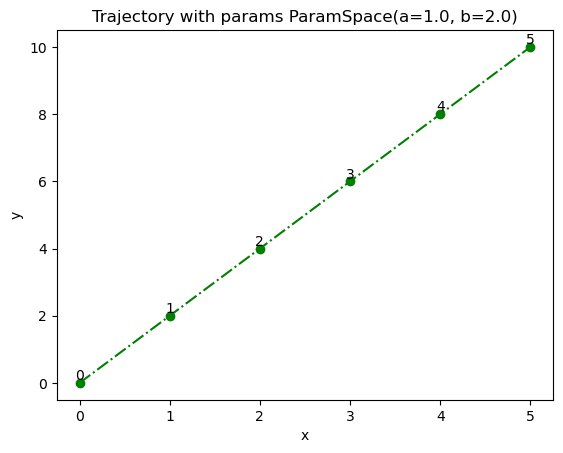

In [7]:
# Run for T steps
trajectory = model.run(params, initial_state, T=5)
print("params:", params)
print("Trajectory:", trajectory)

import matplotlib.pyplot as plt
import numpy as np

plt.figure()
x_values = [state.x for state in trajectory]
y_values = [state.y for state in trajectory]
plt.plot(x_values, y_values, 'o-.', color='green', label=f'Trajectory with params {params}')
for i, (x, y) in enumerate(zip(x_values, y_values)):
    plt.text(x, y, str(i), ha='center', va='bottom')
plt.title(f'Trajectory with params {params}')
plt.xlabel('x')
plt.ylabel('y')


In [8]:

# Batch runs
batch_params = [ParamSpace(a=1.0, b=2.0), ParamSpace(a=0.5, b=-1.5), ParamSpace(a=-1, b=1.0), ParamSpace(a=-.5, b=-2.0)]
batch_initial_states = [StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=1.0, ), StateSpace(x=2.0, y=3.0), StateSpace(x=4.0, y=3.0)]
batch_results = model.batch(batch_params, batch_initial_states, T=5)
print("Batch Results:", batch_results)


Batch Results: [[StateSpace(x=0.0, y=0.0), StateSpace(x=1.0, y=2.0), StateSpace(x=2.0, y=4.0), StateSpace(x=3.0, y=6.0), StateSpace(x=4.0, y=8.0), StateSpace(x=5.0, y=10.0)], [StateSpace(x=1.0, y=1.0), StateSpace(x=1.5, y=-0.5), StateSpace(x=2.0, y=-2.0), StateSpace(x=2.5, y=-3.5), StateSpace(x=3.0, y=-5.0), StateSpace(x=3.5, y=-6.5)], [StateSpace(x=2.0, y=3.0), StateSpace(x=1.0, y=4.0), StateSpace(x=0.0, y=5.0), StateSpace(x=-1.0, y=6.0), StateSpace(x=-2.0, y=7.0), StateSpace(x=-3.0, y=8.0)], [StateSpace(x=4.0, y=3.0), StateSpace(x=3.5, y=1.0), StateSpace(x=3.0, y=-1.0), StateSpace(x=2.5, y=-3.0), StateSpace(x=2.0, y=-5.0), StateSpace(x=1.5, y=-7.0)]]


In [9]:
import pandas as pd

data = pd.DataFrame()
for i, (params, states) in enumerate(zip(batch_params, batch_results)):
    df = pd.DataFrame([vars(s) for s in states])
    df['t'] = df.index
    df['run'] = i
    df['a'] = params.a
    df['b'] = params.b
    data = pd.concat([data, df], axis=0)

data.head()

,x,y,t,run,a,b
0,0.0,0.0,0,0,1.0,2.0
1,1.0,2.0,1,0,1.0,2.0
2,2.0,4.0,2,0,1.0,2.0
3,3.0,6.0,3,0,1.0,2.0
4,4.0,8.0,4,0,1.0,2.0


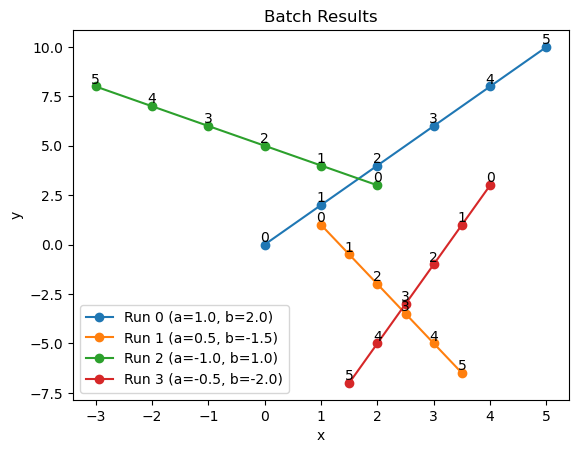

In [10]:
#plotting the batch results
plt.figure()
for i, group in data.groupby('run'):
    plt.plot(group.x, group.y, 'o-', label=f'Run {i}')
    for x, y, t in zip(group.x, group.y, group.t):
        plt.text(x, y, str(t), ha='center', va='bottom')
    plt.title('Batch Results')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(labels=[f'Run {i} (a={group["a"].iloc[0]}, b={group["b"].iloc[0]})' for i, group in data.groupby('run')])
    

### **Explanation**
1. **Dataclasses**: The `ParamSpace` and `StateSpace` classes store parameters and state attributes, making the design clean and type-safe.
2. **Dynamics Function**: Implements the logic for state updates using `params` and `state`.
3. **Model Class**: Encapsulates the simulation logic with:
   - `step` for a single state update.
   - `run` for a trajectory of states.
   - `batch` for multiple trajectories in a single call.
4. **Example Usage**: Demonstrates the system in action with a simple linear dynamics example.
   